In [287]:
import tensorflow as tf
import random
from PIL import Image, ImageFilter
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.utils import Sequence
import pandas as pd
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Flatten, Dense
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


In [138]:
BACKGROUND_DIM = (128,128)
COLOR_CHANNELS = 3
background_ids = [os.path.join('background', i) for i in next(os.walk('background'))[2]]


In [230]:
pokemon_data = pd.read_csv('FirstGenPokemon.csv', usecols=[0,1,3,34])

In [231]:
pokemon_data.rename(columns={' Type1': 'Type',' Name':'Name'},inplace=True)

In [232]:
one_hot = pd.get_dummies(pokemon_data.Type, prefix='type')

In [233]:
pokemon_data = pokemon_data.merge(one_hot, left_index=True, right_index=True)
pokemon_data.drop(columns=["Type"], inplace=True)

In [234]:
pokemon_data

,Number,Name,Legendary,type_bug,type_dragon,type_electric,type_fighting,type_fire,type_ghost,type_grass,type_ground,type_ice,type_normal,type_poison,type_psychic,type_rock,type_water
0,1,Bulbasaur,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,2,Ivysaur,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,3,Venusaur,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,4,Charmander,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,5,Charmeleon,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,147,Dratini,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
147,148,Dragonair,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
148,149,Dragonite,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
149,150,Mewtwo,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [199]:
def generate_image():
        pokemon = pokemon_data.sample()
        
        background = random.choice(background_ids)
        background_img = Image.open(background).resize(BACKGROUND_DIM)
        
        p = os.path.join("pokemons",str(pokemon.Number.values[0])+".png")
        pokemon_img = Image.open(p)
        
        pos = (np.random.randint(0, BACKGROUND_DIM[0]-32), np.random.randint(0, BACKGROUND_DIM[1]-32))
        background_img.paste(pokemon_img, pos, mask=pokemon_img)
        pkmn_mask = np.array(pokemon_img)[:,:,3]/255
        mask = np.zeros(BACKGROUND_DIM)
        mask[pos[1]:pos[1]+32,pos[0]:pos[0]+32] = pkmn_mask
        return background_img, mask, pokemon

In [200]:
def get_pokemon_from_image(image,mask):
    img = np.array(image,dtype=np.uint8)
    mask = mask[..., np.newaxis]
    pkmn = np.where(mask, img, 0)
    
    limits = np.nonzero(pkmn)
    top = np.min(limits[0])
    bottom = np.max(limits[0])
    left = np.min(limits[1])
    right = np.max(limits[1])
    result = pkmn[top:bottom,left:right]
    rows, cols, _ = result.shape
    row_pad = 32 - rows
    col_pad = 32 - cols
    pad_width = [(0, row_pad), (0, col_pad), (0, 0)]
    result = np.pad(result, pad_width, mode="constant", constant_values=0)
    return result

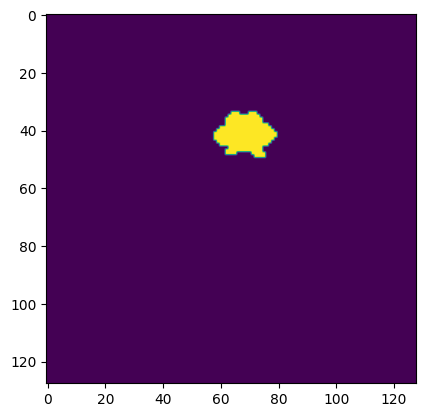

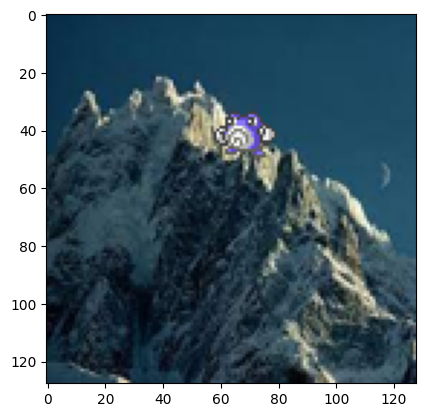

    Number       Name  Legendary  type_bug  type_dragon  type_electric  \
60      61  Poliwhirl          0         0            0              0   

    type_fighting  type_fire  type_ghost  type_grass  type_ground  type_ice  \
60              0          0           0           0            0         0   

    type_normal  type_poison  type_psychic  type_rock  type_water  
60            0            0             0          0           1  


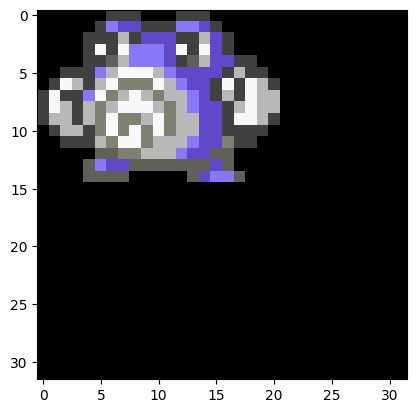

In [309]:
image, mask, pokemon = generate_image()
image_arr = np.array(image)
plt.imshow(mask)
plt.show()
plt.imshow(image)
plt.show()
print(pokemon)
plt.imshow(get_pokemon_from_image(image,mask))
plt.show()

In [312]:
pokemon.drop(columns=["Number","Name"]).values

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int64)

In [145]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet():
    inputs = Input((BACKGROUND_DIM[1], BACKGROUND_DIM[0], COLOR_CHANNELS))

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [146]:
class DataGen(Sequence):
    def __init__(self, batch_size=16,steps=100):
        self.batch_size = batch_size
        self.steps = steps
        self.epoch = 0

    def __len__(self):
        return int(self.steps)


    def __getitem__(self, index):
        x_batch = np.zeros((self.batch_size, BACKGROUND_DIM[1], BACKGROUND_DIM[0], COLOR_CHANNELS))
        mask = np.zeros((self.batch_size, BACKGROUND_DIM[1], BACKGROUND_DIM[0]))

        for i in range(self.batch_size):
            # generate an example image
            sample_im, msk, _ = self.generate_image()
            #if index == 0: self.plot_bounding_box(sample_im.convert('L'), pos).show()
            # put the images to the arrays
            x_batch[i] = np.array(sample_im, dtype=np.uint8)
            mask[i] = msk

        return x_batch, mask

    def generate_image(self):
        pokemon = pokemon_data.sample()
        
        background = random.choice(background_ids)
        background_img = Image.open(background).resize(BACKGROUND_DIM)
        
        p = os.path.join("pokemons",str(pokemon.Number.values[0])+".png")
        pokemon_img = Image.open(p)
        
        pos = (np.random.randint(0, BACKGROUND_DIM[0]-32), np.random.randint(0, BACKGROUND_DIM[1]-32))
        background_img.paste(pokemon_img, pos, mask=pokemon_img)
        pkmn_mask = np.array(pokemon_img)[:,:,3]/255
        mask = np.zeros(BACKGROUND_DIM)
        mask[pos[1]:pos[1]+32,pos[0]:pos[0]+32] = pkmn_mask
        return background_img, mask, pokemon
    

In [150]:
model = build_unet()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
train_Gen = DataGen(batch_size=2,steps=10)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

hist = model.fit(train_Gen,
                 epochs=100,
                 callbacks=[early_stop],
                 verbose=1)


Epoch 1/100
10/10 [==============================] - 13s 982ms/step - loss: 0.3457
Epoch 2/100
10/10 [==============================] - 10s 976ms/step - loss: 0.1051
Epoch 3/100
10/10 [==============================] - 10s 979ms/step - loss: 0.0747
Epoch 4/100
10/10 [==============================] - 10s 986ms/step - loss: 0.0615
Epoch 5/100
10/10 [==============================] - 10s 984ms/step - loss: 0.0535
Epoch 6/100
10/10 [==============================] - 10s 996ms/step - loss: 0.0450
Epoch 7/100
10/10 [==============================] - 10s 1s/step - loss: 0.0403
Epoch 8/100
10/10 [==============================] - 11s 1s/step - loss: 0.0384
Epoch 9/100
10/10 [==============================] - 11s 1s/step - loss: 0.0334
Epoch 10/100
10/10 [==============================] - 11s 1s/step - loss: 0.0322
Epoch 11/100
10/10 [==============================] - 11s 1s/step - loss: 0.0314
Epoch 12/100
10/10 [==============================] - 11s 1s/step - loss: 0.0280
Epoch 13/100
10/10 

In [164]:
model.save("unet")

INFO:tensorflow:Assets written to: unet\assets


INFO:tensorflow:Assets written to: unet\assets


In [299]:
class DataGen2(Sequence):
    def __init__(self, batch_size=16,steps=100):
        self.batch_size = batch_size
        self.steps = steps
        self.epoch = 0
        self.model = tf.keras.models.load_model("unet")

    def __len__(self):
        return int(self.steps)


    def __getitem__(self, index):
        x_batch = np.zeros((self.batch_size, 32, 32, COLOR_CHANNELS))
        y_batch = np.zeros((self.batch_size,15))

        for i in range(self.batch_size):
            # generate an example image
            sample_im, _, pkmn = self.generate_image()
            msk = model.predict(np.array([np.array(sample_im)]),verbose=0)[0]
            m = np.where(np.reshape(msk,BACKGROUND_DIM) > 0.5, 1,0)
            x_batch[i] = np.array(get_pokemon_from_image(sample_im,m), dtype=np.uint8)
            y_batch[i] = pkmn.drop(columns=["Number","Name"]).values

        return x_batch, y_batch

    def generate_image(self):
        pokemon = pokemon_data.sample()
        
        background = random.choice(background_ids)
        background_img = Image.open(background).resize(BACKGROUND_DIM)
        
        p = os.path.join("pokemons",str(pokemon.Number.values[0])+".png")
        pokemon_img = Image.open(p)
        
        pos = (np.random.randint(0, BACKGROUND_DIM[0]-32), np.random.randint(0, BACKGROUND_DIM[1]-32))
        background_img.paste(pokemon_img, pos, mask=pokemon_img)
        pkmn_mask = np.array(pokemon_img)[:,:,3]/255
        mask = np.zeros(BACKGROUND_DIM)
        mask[pos[1]:pos[1]+32,pos[0]:pos[0]+32] = pkmn_mask
        return background_img, mask, pokemon
    
    def get_pokemon_from_image(image,mask):
        img = np.array(image,dtype=np.uint8)
        mask = mask[..., np.newaxis]
        pkmn = np.where(mask, img, 0)
        
        limits = np.nonzero(pkmn)
        top = np.min(limits[0])
        bottom = np.max(limits[0])
        left = np.min(limits[1])
        right = np.max(limits[1])
        result = pkmn[top:bottom,left:right]
        rows, cols, _ = result.shape
        row_pad = 32 - rows
        col_pad = 32 - cols
        pad_width = [(0, row_pad), (0, col_pad), (0, 0)]
        result = np.pad(result, pad_width, mode="constant", constant_values=0)
        return result
    

In [300]:
def make_predictor():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(15, activation='sigmoid'))

    return model

In [311]:
model2 = make_predictor()
model2.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=["accuracy"])
train_Gen = DataGen2(batch_size=8,steps=10)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
hist = model2.fit(train_Gen,
                 epochs=100,
                 callbacks=[early_stop],
                 verbose=1)
model2.save("predictor")

Epoch 1/100
10/10 [==============================] - 19s 2s/step - loss: 5.2770 - accuracy: 0.0875
Epoch 2/100
10/10 [==============================] - 19s 2s/step - loss: 3.5323 - accuracy: 0.2000
Epoch 3/100
10/10 [==============================] - 19s 2s/step - loss: 1.7999 - accuracy: 0.3750
Epoch 4/100
10/10 [==============================] - 20s 2s/step - loss: 1.5007 - accuracy: 0.2875
Epoch 5/100
10/10 [==============================] - 20s 2s/step - loss: 0.8979 - accuracy: 0.4250
Epoch 6/100
10/10 [==============================] - 20s 2s/step - loss: 0.6281 - accuracy: 0.4250
Epoch 7/100
10/10 [==============================] - 21s 2s/step - loss: 0.4166 - accuracy: 0.4875
Epoch 8/100
10/10 [==============================] - 21s 2s/step - loss: 0.3681 - accuracy: 0.6375
Epoch 9/100
10/10 [==============================] - 21s 2s/step - loss: 0.3881 - accuracy: 0.5750
Epoch 10/100
10/10 [==============================] - 22s 2s/step - loss: 0.2800 - accuracy: 0.6000
Epoch 11/

INFO:tensorflow:Assets written to: predictor\assets


INFO:tensorflow:Assets written to: predictor\assets


In [304]:
p = model2.predict(np.array([get_pokemon_from_image(image,m)]))[0]
np.where(p > 0.5, 1,0)

1/1 [==============================] - 0s 10ms/step


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [305]:
pokemon.drop(columns=["Number","Name"]).values

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], dtype=int64)

In [379]:
pkmn_type = {
    0:"Bug",
    1:"Dragon",
    2:"Eletric",
    3:"Fighting",
    4:"Fire",
    5:"Ghost",
    6:"Grass",
    7:"Ground",
    8:"Ice",
    9:"Normal",
    10:"Poison",
    11:"Psychic",
    12:"Rock",
    13:"Water"
}

def pred():
    unet = tf.keras.models.load_model("unet")
    predictor = tf.keras.models.load_model("predictor")
    image, mask, pokemon = generate_image()
    print(pokemon)
    plt.imshow(image)
    plt.show()
    msk = unet.predict(np.array([np.array(image)]),verbose=0)[0]
    m = np.where(np.reshape(msk,BACKGROUND_DIM) > 0.5, 1,0)
    pkmn = get_pokemon_from_image(image,m)
    p = predictor.predict(np.array([pkmn]),verbose=0)[0]
    if p[0] >= 0.9:
        print("Legendary")
    else:
        print("Common")
    print("Type: {t}".format(t=pkmn_type[np.argmax(p[1:])]))
    
    
    

     Number Name  Legendary  type_bug  type_dragon  type_electric  \
150     151  Mew          1         0            0              0   

     type_fighting  type_fire  type_ghost  type_grass  type_ground  type_ice  \
150              0          0           0           0            0         0   

     type_normal  type_poison  type_psychic  type_rock  type_water  
150            0            0             1          0           0  


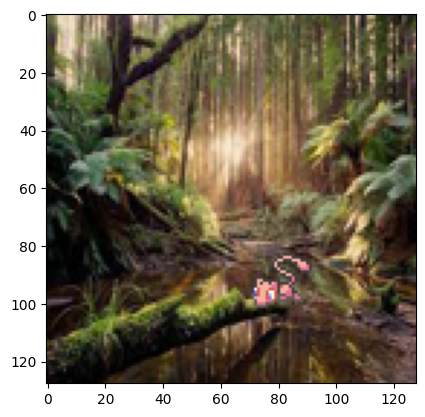

Legendary
Type: Psychic


In [409]:
pred()

    Number    Name  Legendary  type_bug  type_dragon  type_electric  \
93      94  Gengar          0         0            0              0   

    type_fighting  type_fire  type_ghost  type_grass  type_ground  type_ice  \
93              0          0           1           0            0         0   

    type_normal  type_poison  type_psychic  type_rock  type_water  
93            0            0             0          0           0  


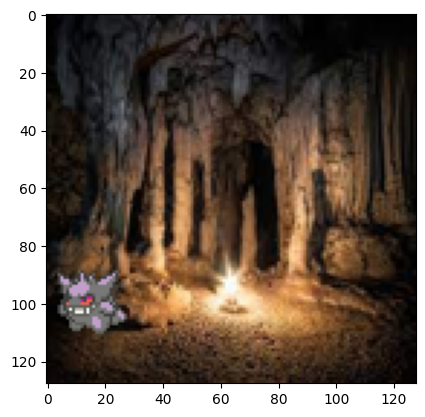

Common
Type: Ghost


In [18]:
pred()